In [184]:
# Porting over the matlab code into python to see if we can reproduce results with the MNE library.

In [185]:
# Import common libraries
import pandas as pd
import numpy as np
import os
from collections import defaultdict
from copy import deepcopy

# Import MNE processing
from mne.viz import plot_compare_evokeds
from mne import Epochs, events_from_annotations, set_log_level

# Import MNE-NIRS processing
import mne
from mne_nirs.channels import get_long_channels
from mne_nirs.channels import picks_pair_to_idx
from mne_nirs.datasets import fnirs_motor_group
from mne.preprocessing.nirs import beer_lambert_law, optical_density,\
    temporal_derivative_distribution_repair, scalp_coupling_index
from mne_nirs.signal_enhancement import enhance_negative_correlation

# Scikit Learn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Import MNE-BIDS processing
from mne_bids import BIDSPath, read_raw_bids

# Import StatsModels
import statsmodels.formula.api as smf

# Import Plotting Library
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:
# Tip for using machine learning for exploratory type data analysis

# Use principal component analysis (PCA) or independent component analysis (ICA), 
# to identify patterns in the fNIRS data that are not immediately obvious. 
# This can be used to identify latent neural networks or to identify different sources of signal variation.

# ==========================================================

# I'm curious how we could incorportate these into the data analsyis pipeline

# Anomaly detection
# Unsupervised learning algorithms such as one-class SVM, Autoencoder, and Isolation Forest can be used to identify outliers or abnormal patterns in the data.

# Time-series analysis
# Techniques such as time-series decomposition, ARIMA, and LSTM can be used to analyze the temporal dynamics of the fNIRS data and identify trends or patterns over time.

In [187]:
# Recurring values that we will keep the same

# Length of the measured interval
interval_length = 15
# How you would like to rename the numeric triggers from Aurora
trigger_id = {'4': 'Control', '2': 'Neutral', '3': 'Inflammatory', '1':'Practice'}
# What files would you like to ignore while looping through subjects
ignore = [".DS_Store", "sub-03"]


# Analyze Each Subjects Data Individually and Return it

In [188]:
def individual_analysis(bids_path):
    
    # Read data with annotations in BIDS format
    # raw_intensity = read_raw_bids(bids_path=bids_path, verbose=False)
    raw_intensity = mne.io.read_raw_snirf(bids_path, verbose=True, preload=False)
    raw_intensity = get_long_channels(raw_intensity, min_dist=0.01)
    
    channel_types = raw_intensity.copy()
    # print(channel_types)
    
    raw_intensity.annotations.rename(trigger_id)

    # Convert signal to optical density and determine bad channels
    raw_od = optical_density(raw_intensity)
    sci = scalp_coupling_index(raw_od, h_freq=1.35, h_trans_bandwidth=0.1)
    raw_od.info["bads"] = list(compress(raw_od.ch_names, sci < 0.5))

    # Down sample and apply signal cleaning techniques
    raw_od.resample(0.8)
    raw_od = temporal_derivative_distribution_repair(raw_od)

    # Convert to haemoglobin and filter
    raw_haemo = beer_lambert_law(raw_od, ppf=0.1)
    raw_haemo = raw_haemo.filter(0.02, 0.3,
                                 h_trans_bandwidth=0.1, l_trans_bandwidth=0.01,
                                 verbose=False)

    # Apply further data cleaning techniques and extract epochs
    raw_haemo = enhance_negative_correlation(raw_haemo)
    # Extract events but ignore those with
    # the word Ends (i.e. drop ExperimentEnds events)
    events, event_dict = events_from_annotations(raw_haemo, verbose=False)
    
    # Remove all STOP triggers to hardcode duration to 30 secs per MNE specs
    events = events[::2]
    # print(events)

    epochs = Epochs(raw_haemo, events, event_id=event_dict, tmin=-1, tmax=15,
                    reject=dict(hbo=200e-6), reject_by_annotation=True,
                    proj=True, baseline=(None, 0), detrend=0,
                    preload=True, verbose=False)

    return raw_haemo, epochs

In [189]:
matrix = [[1,1,1],[2,2,2],[3,3,3]]
np.array(matrix)
test_df = pd.DataFrame(matrix, columns=['Sub-1', 'Sub-2', 'Sub-3']).transpose()
test_df.to_numpy()

array([[1, 2, 3],
       [1, 2, 3],
       [1, 2, 3]])

# Loop through subjects for individual analysis

In [190]:
all_evokeds = defaultdict(list)

root_dir = '../../LabResearch/IndependentStudy/DataAnalysis'

subjects = os.listdir(f'{root_dir}/BIDS_Anon/')

# print(subjects)

for sub in subjects:
    if sub not in ignore:
        print("sub", sub)
        # Create path to file based on experiment info
        f_path = f'{root_dir}/BIDS_Anon/{sub}/nirs/{sub}_task-AnonCom_nirs.snirf'

        # Analyse data and return both ROI and channel results
        raw_haemo, epochs = individual_analysis(f_path)

        for cidx, condition in enumerate(epochs.event_id):
            # all_evokeds[condition].append(epochs[condition].average())
            all_evokeds[condition].append(epochs[condition])

print(all_evokeds)


sub sub-06
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/DataAnalysis/BIDS_Anon/sub-06/nirs/sub-06_task-AnonCom_nirs.snirf
Reading 0 ... 18357  =      0.000 ...  1804.493 secs...
sub sub-07
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/DataAnalysis/BIDS_Anon/sub-07/nirs/sub-07_task-AnonCom_nirs.snirf
Reading 0 ... 17824  =      0.000 ...  1752.099 secs...
sub sub-05
Loading /Users/nolanbrady/Desktop/fNIRs-data-pipeline/python/../../LabResearch/IndependentStudy/DataAnalysis/BIDS_Anon/sub-05/nirs/sub-05_task-AnonCom_nirs.snirf
Reading 0 ... 17061  =      0.000 ...  1677.096 secs...
defaultdict(<class 'list'>, {'Control': [<Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Control': 3>, <Epochs |  3 events (all good), -1.25 - 15 sec, baseline -1.25 – 0 sec, ~171 kB, data loaded,
 'Control': 3>, <Epochs |  3 events (all good), -1.25 - 15 sec, base

# Extract Evoked Amplitude


In [191]:

df = pd.DataFrame(columns=['ID', 'Chroma', 'Condition', 'Value'])
temporal_measurements = []

for idx, evoked in enumerate(all_evokeds):
    subj_id = 0
    for subj_data in all_evokeds[evoked]:
        subj_id += 1
        # can be either "hbo", "hbr", or both
        for chroma in ["hbo", "hbr"]:
            data = deepcopy(subj_data.average(picks=chroma))
            value = data.crop(tmin=-1, tmax=15).data * 1.0e6
            
            # Reshape the data to be a flat numpy array
            value = np.reshape(value, -1)
            temporal_measurements.append(value)

            # Placeholder while we see if PCA gives better results (also how the MNE tutorial said to do it though)
            avg_val = data.crop(tmin=-1, tmax=15).data.mean() * 1.0e6

            # Append metadata and extracted feature to dataframe
            this_df = pd.DataFrame(
                {'ID': subj_id, 'Chroma': chroma, 'Condition': evoked, 'Value': avg_val}, index=[0])
            df = pd.concat([df, this_df], ignore_index=True)

df['Value'] = pd.to_numeric(df['Value'])  # some Pandas have this as object
df

# You can export the dataframe for analysis in your favorite stats program
# df.to_csv("stats-export.csv")

,ID,Chroma,Condition,Value
0,1,hbo,Control,1.684122
1,1,hbr,Control,-0.570320
2,2,hbo,Control,0.254804
3,2,hbr,Control,-0.380185
4,3,hbo,Control,-0.013204
5,3,hbr,Control,2.376384
6,1,hbo,Inflammatory,1.050461
7,1,hbr,Inflammatory,-0.307104
8,2,hbo,Inflammatory,4.735021
9,2,hbr,Inflammatory,-1.830414


In [192]:
# temporal_measurements
# df
temporal_measurements = np.array(temporal_measurements)
temporal_measurements.shape

(24, 252)

In [193]:
# Create a df of all the temporal samples to run PCA on instead of taking the average
# You can use .transpose() to rotate the table.

measurements_df = pd.DataFrame(temporal_measurements)
measurements_df

,0,1,2,3,4,5,6,7,8,9,...,242,243,244,245,246,247,248,249,250,251
0,0.161684,-0.161684,1.574263,4.232403,3.587859,2.717065,0.850281,1.674958,2.721378,2.154469,...,2.213198,1.383067,-0.984573,0.437291,0.562221,0.197796,1.265040,2.064910,3.187037,3.004558
1,-0.055374,0.055374,-0.539155,-1.449518,-1.228774,-0.930543,-0.291205,-0.573641,-0.932020,-0.737865,...,-0.472378,-0.295197,0.210144,-0.093334,-0.119999,-0.042217,-0.270006,-0.440727,-0.680230,-0.641283
2,0.606796,-0.606796,-2.085026,-1.254237,-1.568393,-5.003764,-6.718554,-6.773773,-5.891003,-2.915713,...,-2.228402,-1.945011,-3.047765,-9.096303,-5.726347,-0.472008,-1.423577,-1.024713,-5.189065,-10.324045
3,-0.408698,0.408698,1.404339,0.844773,1.056368,3.370213,4.525185,4.562377,3.967800,1.963837,...,0.999331,0.872244,1.366775,4.079252,2.567990,0.211673,0.638406,0.459534,2.327045,4.629835
4,0.743051,-0.743051,-0.639698,7.213474,7.940565,2.341426,5.531505,7.049150,5.177131,9.920525,...,0.907183,-3.360025,-4.221259,-6.406712,-10.269180,-5.670966,-2.921780,-2.979737,-1.003421,-0.769864
5,-0.259292,0.259292,0.223226,-2.517182,-2.770904,-0.817054,-1.930249,-2.459840,-1.806589,-3.461822,...,-0.235228,0.871238,1.094551,1.661229,2.662747,1.470453,0.757603,0.772631,0.260182,0.199622
6,0.262275,-0.262275,-0.798846,-1.918071,-1.329328,-0.936125,-0.163749,-0.001683,1.836479,2.663279,...,-1.251369,-1.626792,-2.012015,-2.729760,-2.262592,-1.877387,-2.047820,-1.915725,-2.180086,-2.681396
7,-0.089824,0.089824,0.273590,0.656903,0.455270,0.320605,0.056081,0.000576,-0.628959,-0.912123,...,0.267088,0.347217,0.429438,0.582631,0.482920,0.400703,0.437080,0.408886,0.465310,0.572308
8,-1.447184,1.447184,0.700813,3.059249,6.998061,9.646200,13.407457,13.223634,11.260465,10.013790,...,7.759056,17.304160,14.445539,10.493316,4.338561,3.253155,2.466058,-1.172557,-10.180442,-21.075611
9,0.974730,-0.974730,-0.472022,-2.060513,-4.713443,-6.497059,-9.030399,-8.906588,-7.584324,-6.744644,...,-3.479562,-7.760080,-6.478126,-4.705745,-1.945635,-1.458883,-1.105908,0.525835,4.565436,9.451393


# Use PCA in order to reduce the number of points in the temporal readings

## To do
- figure out if PCA is effective for the dataset or not
- Does the dataset need to be scaled (or should it normalized)
- Why are HBO and HBR the same value?

In [201]:
# scaler = StandardScaler()
# scaler.fit_transform(measurements_df)
measurements_df = (measurements_df - measurements_df.mean()) / measurements_df.std()
# measurements_df

pca = PCA(n_components=1)

reduced_measurements = pca.fit_transform(measurements_df)

df['Value'] = reduced_measurements

df


,ID,Chroma,Condition,Value
0,1,hbo,Control,-3.759285
1,1,hbr,Control,1.682014
2,2,hbo,Control,-0.656957
3,2,hbr,Control,0.811912
4,3,hbo,Control,8.237063
5,3,hbr,Control,-1.828070
6,1,hbo,Inflammatory,-6.300972
7,1,hbr,Inflammatory,2.540696
8,2,hbo,Inflammatory,-18.245933
9,2,hbr,Inflammatory,8.519415


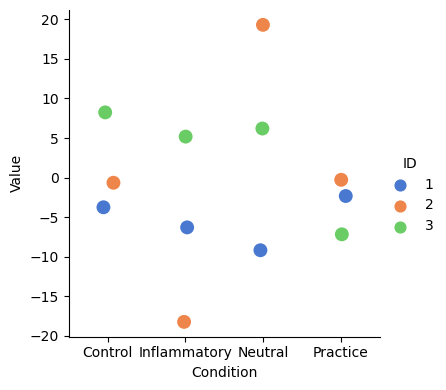

In [207]:
# Plot the Data
sns.catplot(x="Condition", y="Value", hue="ID", data=df.query("Chroma == 'hbo'"), ci=None, palette="muted", height=4, s=10)
plt.show()

In [203]:
# Inflammatory vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Neutral', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/nolanbrady/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:                MixedLM    Dependent Variable:    Value   
No. Observations:     6          Method:                REML    
No. Groups:           3          Scale:                 170.2955
Min. group size:      2          Log-Likelihood:        -17.0494
Max. group size:      2          Converged:             Yes     
Mean group size:      2.0                                       
----------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
----------------------------------------------------------------
Intercept            -6.457    7.534 -0.857 0.391 -21.224  8.310
Condition[T.Neutral] 11.895   10.655  1.116 0.264  -8.988 32.779
Group Var             0.000                                     
================================================================

"""

In [204]:
# Control vs Neutral Prompt Analysis

input_data = df.query("Condition in ['Control', 'Neutral']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM    Dependent Variable:    Value   
No. Observations:    6          Method:                REML    
No. Groups:          3          Scale:                 95.0277 
Min. group size:     2          Log-Likelihood:        -16.3201
Max. group size:     2          Converged:             Yes     
Mean group size:     2.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z   P>|z|  [0.025 0.975]
---------------------------------------------------------------
Intercept             1.274    6.353 0.200 0.841 -11.179 13.726
Condition[T.Neutral]  4.164    7.959 0.523 0.601 -11.436 19.765
Group Var            26.072   10.675                           
===============================================================

"""

In [205]:
# Control vs Inflam

input_data = df.query("Condition in ['Control', 'Inflammatory']")
input_data = input_data.query("Chroma in ['hbo']")

model = smf.mixedlm("Value ~ Condition", input_data, groups=input_data["ID"]).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM      Dependent Variable:      Value   
No. Observations:      6            Method:                  REML    
No. Groups:            3            Scale:                   36.4792 
Min. group size:       2            Log-Likelihood:          -15.3089
Max. group size:       2            Converged:               Yes     
Mean group size:       2.0                                           
---------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
---------------------------------------------------------------------
Intercept                  1.274    5.415  0.235 0.814  -9.340 11.887
Condition[T.Inflammatory] -7.731    4.931 -1.568 0.117 -17.396  1.935
Group Var                 51.490   16.327                            
=====================================================================

"""